In [139]:
import numpy as np
import pandas as pd
from abc import ABC, abstractmethod
import gymnasium as gym
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import scipy.stats
from IPython.display import clear_output
from time import sleep
from tqdm import tqdm
import matplotlib.animation as animation
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
class Agent(ABC):
    def __init__(self, environment, student_id):
        self.env = environment
        self.seed = student_id
        self.q_table = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        self.all_rewards = []
        self.learning_rates = []
        self.epsilons = []

        
    def choose_action_with_epsilon_greedy(self, epsilon, state):
        p = np.random.random()
        if p < epsilon:
            action = self.env.action_space.sample() # Explore action space
        else:
            action = np.argmax(self.q_table[state]) # Exploit learned values
        return action
    
    
    def take_action(self, action):
        State, Reward, is_done, _, _ = self.env.step(action)
        return State, Reward, is_done
    
    
    @abstractmethod
    def step(self):
        pass

    
    def reset(self):
        self.q_table = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        self.all_rewards = []
        self.each_episode_steps = []
        self.learning_rates = []
        self.epsilons = []
        self.returns = np.zeros([self.env.observation_space.n, self.env.action_space.n], dtype=object)
        self.policy = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        for s in range(self.env.observation_space.n):
            self.policy[s] = np.ones(self.env.action_space.n)/self.env.action_space.n
            for a in range(self.env.action_space.n):
                self.returns[s, a] = []
        
    
    def get_rewards(self, mode):
        if mode == 'sum':
            rewards = [np.sum(r) for r in self.all_rewards]
        elif mode == 'mean':
            rewards = [np.mean(r) for r in self.all_rewards]
        return(rewards) 
            
        
    def train(self, episodes):
        self.reset()
        with tqdm(range(1, episodes+1)) as train:
            for i in train:
                
                if self.ep_mode == 'decaying':
                    self.epsilon = 0.9*np.exp(-i/(0.1*episodes))
                else:
                    self.epsilon = self.ep_mode
                    
                if self.alpha_mode == 'decaying':
                    self.alpha = 0.9*np.exp(-i/(0.1*episodes))
                else:
                    self.alpha = self.alpha_mode

                self.step()

                self.all_rewards.append(self.episode_reward)
                self.each_episode_steps.append(len(self.episode_reward))
                self.learning_rates.append(self.alpha)
                self.epsilons.append(self.epsilon)
                train.set_postfix(Episode_Reward=np.sum(self.episode_reward), 
                                  Steps=len(self.episode_reward), refresh=True)
                


In [3]:
class Q_Learning(Agent):
    def __init__(self, alpha, gamma, environment, student_id, epsilon='decaying'):
        super(Q_Learning, self).__init__(environment, student_id)
        self.alpha_mode = alpha
        self.ep_mode = epsilon
        self.gamma = gamma
        
    def step(self):
        state, _ = self.env.reset(seed = self.seed)
        self.epochs = 0
        self.episode_reward = []
        done = False
        while not done:
            action = self.choose_action_with_epsilon_greedy(self.epsilon, state)
            
            next_state, reward, done = self.take_action(action)
            self.episode_reward.append(reward)
            
            self.q_table[state, action] += self.alpha * (reward + \
                                                         self.gamma * np.max(self.q_table[next_state]) - \
                                                         self.q_table[state, action])
            state = next_state
            self.epochs += 1
                    
            

In [4]:
class Sarsa(Agent):
    def __init__(self, alpha, gamma, environment, student_id, epsilon='decaying'):
        super(Sarsa, self).__init__(environment, student_id)
        self.alpha_mode = alpha
        self.ep_mode = epsilon
        self.gamma = gamma
        
    def step(self):
        state, _ = self.env.reset(seed = self.seed)
        self.epochs = 0
        self.episode_reward = []
        action = self.choose_action_with_epsilon_greedy(self.epsilon, state)
        done = False
        while not done:            
            next_state, reward, done = self.take_action(action)
            self.episode_reward.append(reward)
            
            next_action = self.choose_action_with_epsilon_greedy(self.epsilon, next_state)
            
            self.q_table[state, action] += self.alpha * (reward + \
                                                         self.gamma * self.q_table[next_state, next_action] - \
                                                         self.q_table[state, action])
            state = next_state
            action = next_action
            self.epochs += 1
                    


In [5]:
class TreeBackup(Agent):
    def __init__(self, n, alpha, gamma, environment, student_id, epsilon='decaying'):
        super(TreeBackup, self).__init__(environment, student_id)
        self.alpha_mode = alpha
        self.ep_mode = epsilon
        self.gamma = gamma
        self.n = n
        
    def step(self):
        R, S, A = {}, {}, {}
        
        S[0], _ = self.env.reset(seed = self.seed)
        A[0] = self.choose_action_with_epsilon_greedy(0.1, S[0])
        
        T = np.inf
        t = 0
        while True:
            if t < T:
                S[t+1], R[t+1], done = self.take_action(A[t])
                
                if done:
                    T = t + 1
                else:
                    A[t+1] = self.choose_action_with_epsilon_greedy(0.1, S[t+1])
                        
            tau = t - self.n + 1
            if tau >= 0:
                if t + 1 >= T:
                    G = R[T]
                else:
                    pi = np.eye(self.env.action_space.n)[np.argmax(S[t+1])]
                    G = R[t+1] + self.gamma * np.sum(pi*self.q_table[S[t+1]])
                    
                for k in range(min(t, T - 1), tau, -1):
                    pi = np.eye(self.env.action_space.n)[np.argmax(S[k])]
                    G = R[k] + self.gamma * ( G * pi[A[k]] + np.sum(np.delete(pi*self.q_table[S[k]], A[k])))
                
                self.q_table[S[tau], A[tau]] += self.alpha * (G - self.q_table[S[tau], A[tau]])
            
            t += 1
            if tau == T-1:
                break
                
        self.episode_reward = list(R.values()).copy()
                    


In [59]:
class OnPolicyMC(Agent):
    def __init__(self, gamma, environment, student_id, epsilon='decaying'):
        super(OnPolicyMC, self).__init__(environment, student_id)
        self.alpha_mode = 'decaying'
        self.ep_mode = epsilon
        self.gamma = gamma
        
    def step(self):
        S_A, R = {}, {}
        state, _ = self.env.reset(seed = self.seed)
        t = 0
        while True:
            
            action = np.random.choice(a=range(self.env.action_space.n), p=self.policy[state])
#             action = self.choose_action_with_epsilon_greedy(self.epsilon, state)
            
            next_state, reward, done = self.take_action(action)
            S_A[t] = (state, action)
            R[t+1] = reward
            state = next_state
            
            t += 1
            if done or t == 10000: break

        self.episode_reward = list(R.values())
        
        T = len(S_A)
        G = 0
        for t in range(T-1, -1, -1):
            
            G = self.gamma*G + R[t+1]
            if S_A[t] not in list(S_A.values())[:t]:
                
                self.returns[S_A[t]].append(G)
                self.q_table[S_A[t]] = np.mean(self.returns[S_A[t]])
                
                A_star = np.argmax(self.q_table[S_A[t][0]])
                for a in range(self.env.action_space.n):
                    if a == A_star:
                        self.policy[S_A[t][0], a] = 1 - self.epsilon + self.epsilon/self.env.action_space.n
                    else:
                        self.policy[S_A[t][0], a] = self.epsilon/self.env.action_space.n
        
                    

In [7]:
def repeat(repeats, episodes, model):
    rewards = np.zeros((repeats, episodes))
    q_tables = np.zeros([repeats, env.observation_space.n, env.action_space.n])
    learning_rates = np.zeros((repeats, episodes))
    epsilons = np.zeros((repeats, episodes))
    start = time.time()
    for rep in range(repeats):
        clear_output(wait=True)
        print("REPEAT {}/{} :".format(rep+1, repeats))
        model.train(episodes)
        rewards[rep], q_tables[rep] = model.get_rewards(mode='sum'), model.q_table
        learning_rates[rep], epsilons[rep] = model.learning_rates, model.epsilons
    
    print(f'Elapsed Time: In average {(time.time() - start)/repeats:.3f}s for each repeat')
    return(rewards, q_tables, learning_rates, epsilons)


In [8]:
def rewards_plot(datas, labels, repeats, episodes, sliding_win, CI, window_size=50, CL=0.95, best_reward=5):
    fig, ax = plt.subplots(figsize=(7,4))
    for idx, data in enumerate(datas):
        if sliding_win:
            df = pd.DataFrame(data.copy())
            for row in range(repeats):
                df.iloc[row,:] = df.iloc[row,:].rolling(window=window_size, min_periods=1, center=True).mean().copy()
            plot_data = np.mean(df, axis=0)
        else:
            plot_data = np.mean(data, axis=0)
        data_mean, data_std = np.mean(df, axis=0), np.std(df, axis=0)
        tscore  = np.abs(scipy.stats.t.ppf(q=(1+CL)/2, df=repeats-1))
        ci_up   = data_mean + tscore*data_std/np.sqrt(repeats)
        ci_down = data_mean - tscore*data_std/np.sqrt(repeats)

        plt.plot(plot_data, label=labels[idx])
        plt.ylim(np.min(plot_data))
        if CI:
            plt.fill_between(range(1,episodes+1), ci_up, ci_down, alpha=0.3)
            
    plt.axhline(y=best_reward, color='r', linestyle='--', label=f'Optimal Reward (={best_reward})')
    plt.title('Rewards Plot', fontsize=20)
    plt.xlabel('Episode')
    plt.ylabel('Total Rewards per Episode')
    plt.grid()
    plt.legend(fontsize=12)
    sns.despine()


In [9]:
def regrets_plot(datas, labels, repeats, episodes, sliding_win, CI, window_size=50, CL=0.95, best_reward=5):
    plt.figure(figsize=(7,4))
    for idx, data in enumerate(datas):
        data = np.cumsum(best_reward-data, axis=1)
        if sliding_win:
            df = pd.DataFrame(data.copy())
            for row in range(repeats):
                df.iloc[row,:] = df.iloc[row,:].rolling(window=window_size, min_periods=1, center=True).mean().copy()
            plot_data = np.mean(df, axis=0)
        else:
            plot_data = np.mean(data, axis=0)
        data_mean, data_std = np.mean(df, axis=0), np.std(df, axis=0)
        tscore  = np.abs(scipy.stats.t.ppf(q=(1+CL)/2, df=repeats-1))
        ci_up   = data_mean + tscore*data_std/np.sqrt(repeats)
        ci_down = data_mean - tscore*data_std/np.sqrt(repeats)

        plt.plot(plot_data, label=labels[idx])
        if CI:
            plt.fill_between(range(1,episodes+1), ci_up, ci_down, alpha=0.3)
            
    plt.title('Regrets Plot', fontsize=20)
    plt.xlabel('Episode')
    plt.ylabel('Total Regrets per Episode')
    plt.grid()
    plt.legend(fontsize=12)
    sns.despine()


In [148]:
def render(q_table, rewards, save_name, episodes=20, seed=476):
    best_model = q_table[np.argmax(rewards[:,-1])]
    fig = plt.figure()
    viewer = fig.add_subplot(111)
    plt.ion()  # Turns interactive mode on (probably unnecessary)
    fig.show() # Initially shows the figure
    state, _ = env.reset(seed = seed)
    images = [Image.fromarray(np.uint8(env.render())).convert('RGB')]
    for ep in range(episodes):
        action = np.argmax(best_model[state])
        next_state, reward, done, _, _ = env.step(action)
        images.append(Image.fromarray(np.uint8(env.render())).convert('RGB'))
        viewer.clear()               # Clears the previous image
        viewer.imshow(env.render())  # Loads the new image
        plt.axis('off')
        plt.pause(.5)                # Delay in seconds
        fig.canvas.draw()            # Draws the image to the screen
        state = next_state
        if done: break
            
    images[0].save(save_name, format='GIF', append_images=images[1:],
                   save_all=True, duration=500, loop=0)

In [105]:
def test(q_table, rewards, episodes=20, seed=476):
    best_model = q_table[np.argmax(rewards[:,-1])]
    rewards = []
    steps = []
    for ep in range(episodes):
        rwrd = []
        state, _ = env.reset(seed = seed)
        for i in range(30):
            action = np.argmax(best_model[state])
            state, reward, done, _, _ = env.step(action)
            rwrd.append(reward)
            if done: 
                break
        steps.append(len(rwrd))
        rewards.append(sum(rwrd))
        
    print(f'Best Model:\n        Reward: {max(rewards)}\n        Steps: {min(steps)}')        
    plt.plot(rewards, 'r')
    plt.title(f'Best model test for {episodes} times', fontsize=20)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.grid()
    sns.despine()

---
---
# Runnig Algorithms

### Parameters:

In [12]:
env = gym.make('Taxi-v3', render_mode="rgb_array").env
student_id = 476
gamma = 0.9
repeats = 20
episodes = 2000
epsilon = 0.1
alpha = 0.1

### Environment:

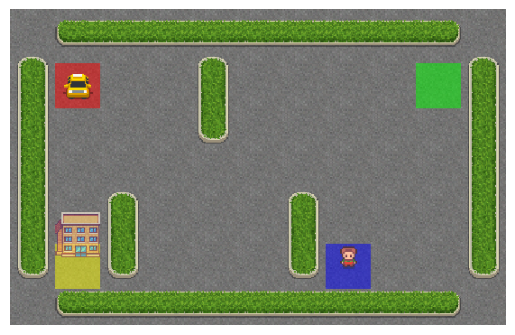

In [138]:
env.reset(seed = student_id)
plt.imshow(env.render())
plt.axis('off');

---
# Q-Learning

---
### with decaying LR

#### Training

In [13]:
qlearning_d = Q_Learning(alpha='decaying', epsilon='decaying', 
                         gamma=0.9, environment=env, student_id=student_id)
rewards_QL_d, q_tables_QL_d, learning_rates_QL_d, epsilons_QL_d = repeat(repeats=repeats, episodes=episodes,
                                                                         model=qlearning_d)

REPEAT 20/20 :


100%|█████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 526.96it/s, Episode_Reward=5, Steps=16]

Elapsed Time: In average 3.944s for each repeat


#### Running best model

<IPython.core.display.Javascript object>


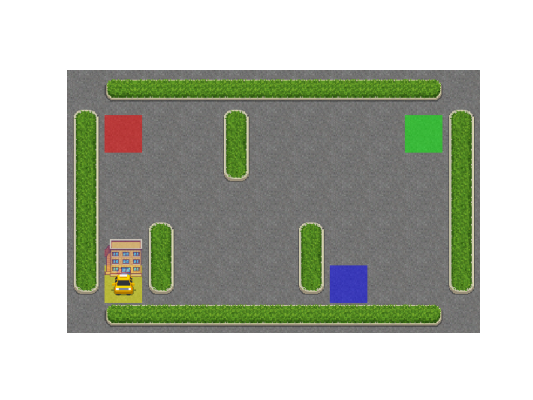

In [149]:
%matplotlib notebook
render(q_tables_QL_d, rewards_QL_d, save_name='Q_learnig with decaying LR.gif')

#### Testing best model

Best Model:
        Reward: 5
        Steps: 16


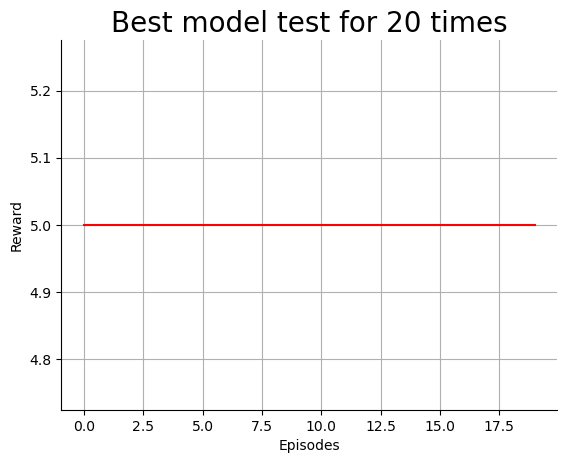

In [106]:
%matplotlib inline
test(q_tables_QL_d, rewards_QL_d)

---
### with constant LR

#### Training

In [16]:
qlearning_c = Q_Learning(alpha=alpha, epsilon='decaying', 
                         gamma=0.9, environment=env, student_id=student_id)
rewards_QL_c, q_tables_QL_c, learning_rates_QL_c, epsilons_QL_c = repeat(repeats=repeats, episodes=episodes, 
                                                                         model=qlearning_c)

REPEAT 20/20 :


100%|█████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 458.36it/s, Episode_Reward=5, Steps=16]

Elapsed Time: In average 4.414s for each repeat


#### Running best model

<IPython.core.display.Javascript object>


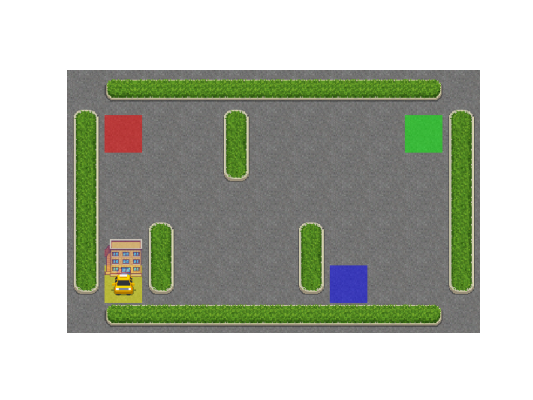

In [150]:
%matplotlib notebook
render(q_tables_QL_c, rewards_QL_c, save_name='Q_learnig with constant LR.gif')

#### Testing best model

Best Model:
        Reward: 5
        Steps: 16


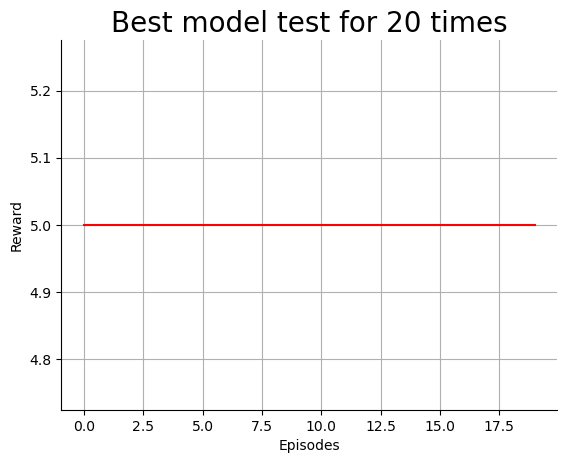

In [107]:
%matplotlib inline
test(q_tables_QL_c, rewards_QL_c)

---
### Comparison

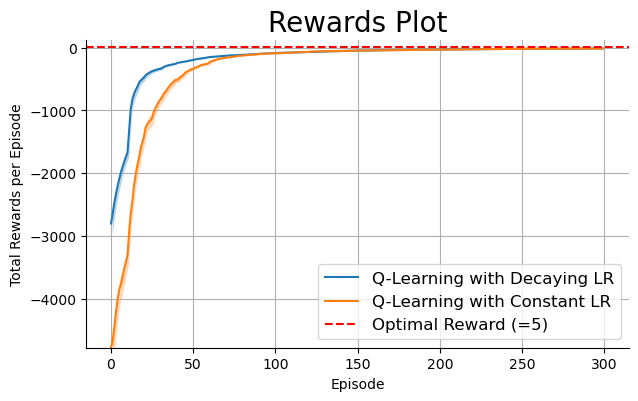

In [19]:
rewards_plot(datas=[rewards_QL_d[:,:300], rewards_QL_c[:,:300]], 
             labels=['Q-Learning with Decaying LR', 'Q-Learning with Constant LR'], 
             repeats=20, episodes=300, sliding_win=True, CI=True, window_size=20)

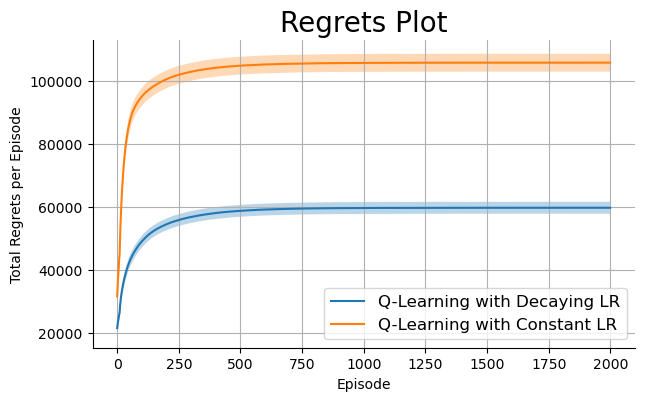

In [20]:
regrets_plot(datas=[rewards_QL_d, rewards_QL_c],
             labels=['Q-Learning with Decaying LR', 'Q-Learning with Constant LR'], 
             repeats=20, episodes=2000, sliding_win=True, CI=True, window_size=20)

---
# Sarsa

#### Training

In [21]:
sarsa = Sarsa(alpha=alpha, epsilon='decaying',
              gamma=gamma, environment=env, student_id=student_id)
rewards_QL_SS, q_tables_QL_SS, learning_rates_QL_SS, epsilons_QL_SS = repeat(repeats=repeats, episodes=episodes,
                                                                             model=sarsa)

REPEAT 20/20 :


100%|█████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 420.83it/s, Episode_Reward=5, Steps=16]


Elapsed Time: In average 4.856s for each repeat


#### Running best model

<IPython.core.display.Javascript object>


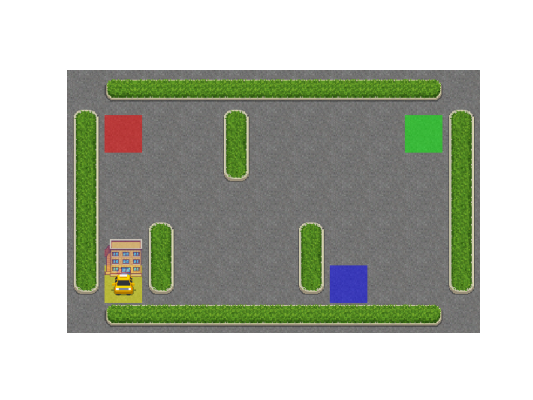

In [151]:
%matplotlib notebook
render(q_tables_QL_SS, rewards_QL_SS, save_name='Sarsa.gif')

#### Testing best model

Best Model:
        Reward: 5
        Steps: 16


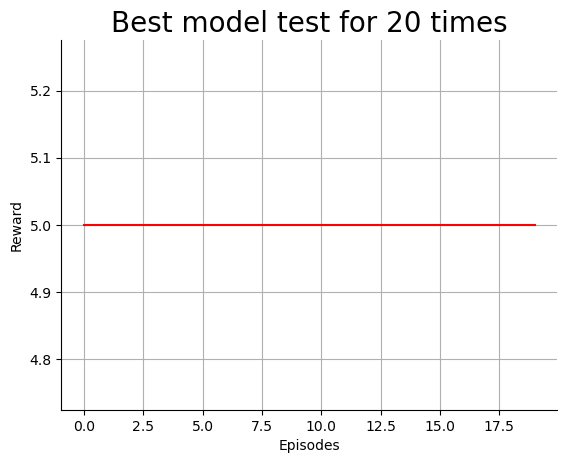

In [108]:
%matplotlib inline
test(q_tables_QL_SS, rewards_QL_SS)

---
# n-Step Tree Backup

### n=1

#### Training

In [24]:
tree_1 = TreeBackup(n=1, alpha=alpha, epsilon='decaying',
                    gamma=gamma, environment=env, student_id=student_id)
rewards_TB_1, q_tables_TB_1, learning_rates_TB_1, epsilons_TB_1 = repeat(repeats=repeats, episodes=episodes,
                                                                         model=tree_1)

REPEAT 20/20 :


100%|████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 302.90it/s, Episode_Reward=-7, Steps=19]

Elapsed Time: In average 6.548s for each repeat


#### Running best model

<IPython.core.display.Javascript object>


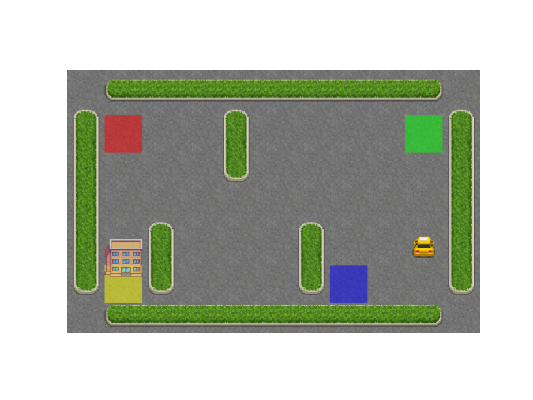

In [152]:
%matplotlib notebook
render(q_tables_TB_1, rewards_TB_1, save_name='1_step tree backup.gif')

#### Testing best model

Best Model:
        Reward: -30
        Steps: 30


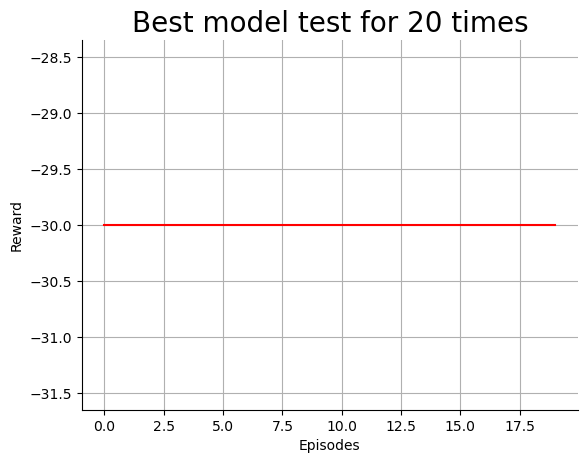

In [109]:
%matplotlib inline
test(q_tables_TB_1, rewards_TB_1)

---
### n=3

#### Training

In [30]:
tree_3 = TreeBackup(n=3, alpha=alpha, epsilon='decaying',
                    gamma=gamma, environment=env, student_id=student_id)
rewards_TB_3, q_tables_TB_3, learning_rates_TB_3, epsilons_TB_3 = repeat(repeats=repeats, episodes=episodes,
                                                                         model=tree_3)

REPEAT 20/20 :


100%|█████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 185.02it/s, Episode_Reward=1, Steps=20]


Elapsed Time: In average 10.715s for each repeat


#### Running best model

<IPython.core.display.Javascript object>


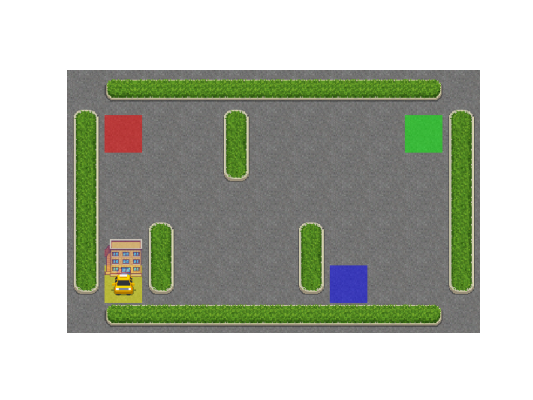

In [153]:
%matplotlib notebook
render(q_tables_TB_3, rewards_TB_3, save_name='3_step tree backup.gif')

#### Testing best model

Best Model:
        Reward: 5
        Steps: 16


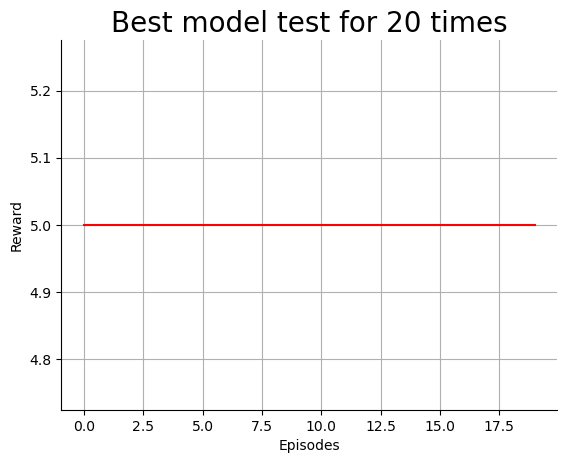

In [110]:
%matplotlib inline
test(q_tables_TB_3, rewards_TB_3)

---
### n=5

#### Training

In [39]:
tree_5 = TreeBackup(n=5, alpha=alpha, epsilon='decaying',
                    gamma=gamma, environment=env, student_id=student_id)
rewards_TB_5, q_tables_TB_5, learning_rates_TB_5, epsilons_TB_5 = repeat(repeats=repeats, episodes=episodes,
                                                                         model=tree_5)

REPEAT 20/20 :


100%|████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 134.73it/s, Episode_Reward=-5, Steps=17]


Elapsed Time: In average 15.134s for each repeat


#### Running best model

<IPython.core.display.Javascript object>


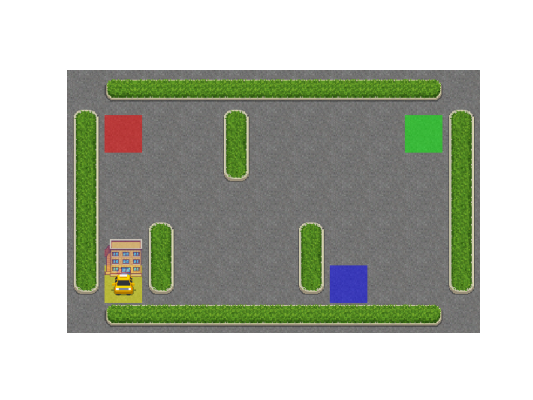

In [154]:
%matplotlib notebook
render(q_tables_TB_5, rewards_TB_5, save_name='5_step tree backup.gif')

#### Testing best model

Best Model:
        Reward: 5
        Steps: 16


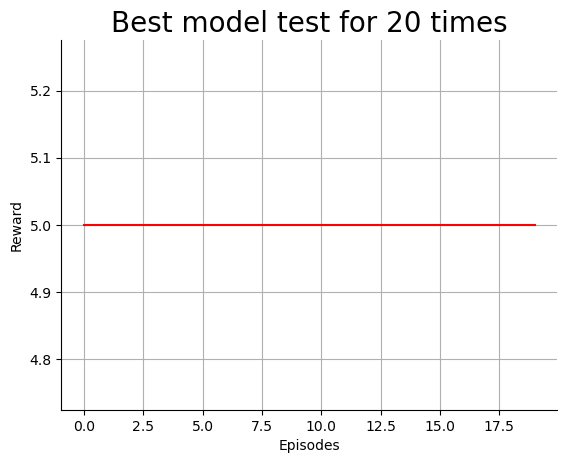

In [111]:
%matplotlib inline
test(q_tables_TB_5, rewards_TB_5)

---
### Comparison

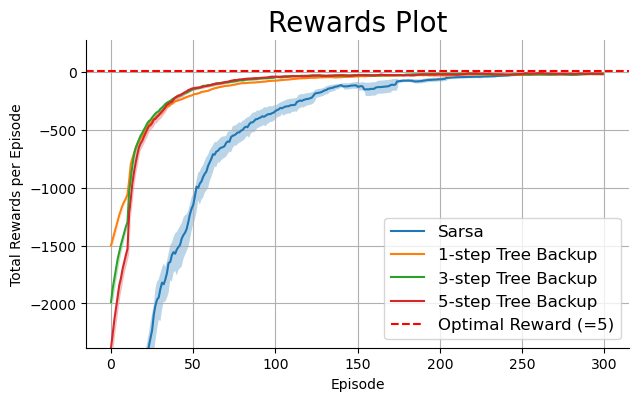

In [42]:
rewards_plot(datas=[rewards_QL_SS[:,:300], rewards_TB_1[:,:300], rewards_TB_3[:,:300], rewards_TB_5[:,:300]],
             labels=['Sarsa', '1-step Tree Backup', '3-step Tree Backup', '5-step Tree Backup'], 
             repeats=20, episodes=300, sliding_win=True, CI=True, window_size=20)

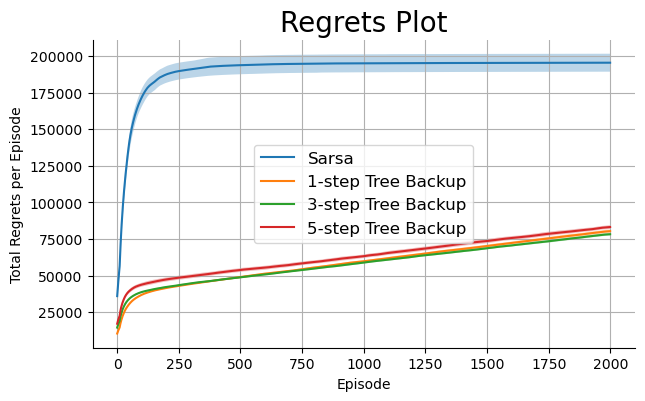

In [43]:
regrets_plot(datas=[rewards_QL_SS, rewards_TB_1, rewards_TB_3, rewards_TB_5],
             labels=['Sarsa', '1-step Tree Backup', '3-step Tree Backup', '5-step Tree Backup'], 
             repeats=20, episodes=2000, sliding_win=True, CI=True, window_size=20)

---
# On-Policy MonteCarlo

---
### with decaying epsilon

#### Training

In [60]:
onMC_d = OnPolicyMC(gamma=gamma, epsilon='decaying', environment=env, student_id=student_id)
rewards_OnMC_d, q_tables_OnMC_d, learning_rates_OnMC_d, epsilons_OnMC_d = repeat(repeats=10, episodes=1000,
                                                                                 model=onMC_d)

REPEAT 10/10 :


100%|█████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 173.08it/s, Episode_Reward=3, Steps=18]


Elapsed Time: In average 137.481s for each repeat


#### Running best model

<IPython.core.display.Javascript object>


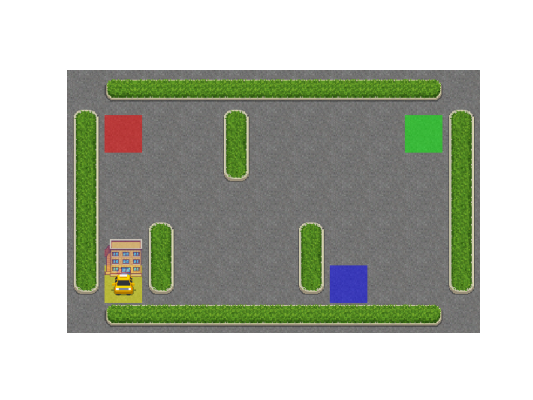

In [155]:
%matplotlib notebook
render(q_tables_OnMC_d, rewards_OnMC_d, save_name='On_policy MC with decaying epsilon.gif')

#### Testing best model

Best Model:
        Reward: 5
        Steps: 16


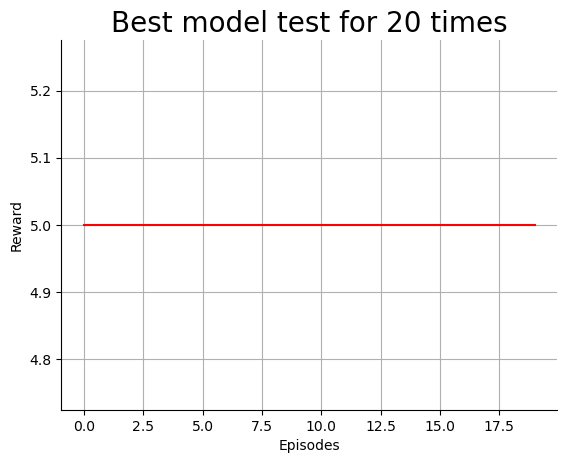

In [112]:
%matplotlib inline
test(q_tables_OnMC_d, rewards_OnMC_d)

---
### with constant epsilon

#### Training

In [116]:
onMC_c = OnPolicyMC(gamma=gamma, epsilon=epsilon, environment=env, student_id=student_id)
rewards_OnMC_c, q_tables_OnMC_c, learning_rates_OnMC_c, epsilons_OnMC_c = repeat(repeats=10, episodes=1000, 
                                                                                 model=onMC_c)

REPEAT 10/10 :


100%|███████████████████████████████████████████| 1000/1000 [25:10<00:00,  1.51s/it, Episode_Reward=-11530, Steps=1e+4]


Elapsed Time: In average 1249.600s for each repeat


#### Running best model

<IPython.core.display.Javascript object>


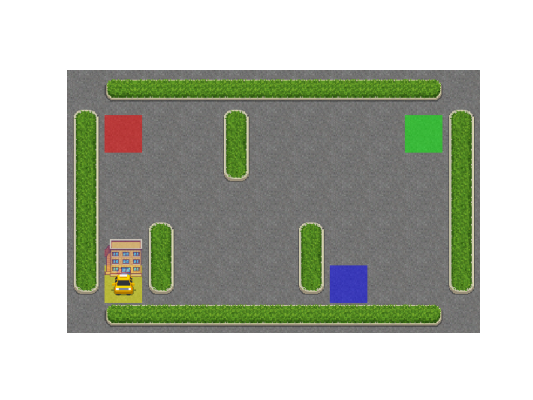

In [156]:
%matplotlib notebook
render(q_tables_OnMC_c, rewards_OnMC_c, save_name='On_policy MC with constant epsilon.gif')

#### Testing best model

Best Model:
        Reward: 1
        Steps: 20


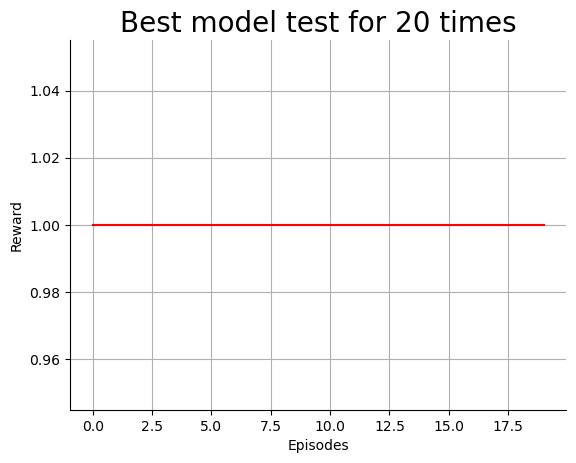

In [118]:
%matplotlib inline
test(q_tables_OnMC_c, rewards_OnMC_c)

---
### Comparison

(-17500.0, 2500.0)

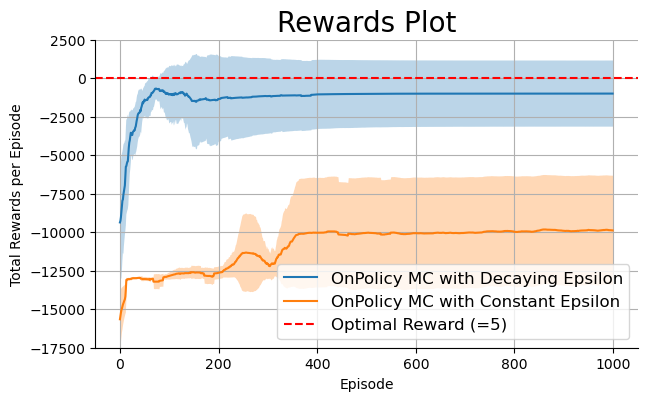

In [130]:
%matplotlib inline
rewards_plot(datas=[rewards_OnMC_d, rewards_OnMC_c],
             labels=['OnPolicy MC with Decaying Epsilon', 'OnPolicy MC with Constant Epsilon'], 
             repeats=10, episodes=1000, sliding_win=True, CI=True, window_size=20)
plt.ylim(-17500, 2500)

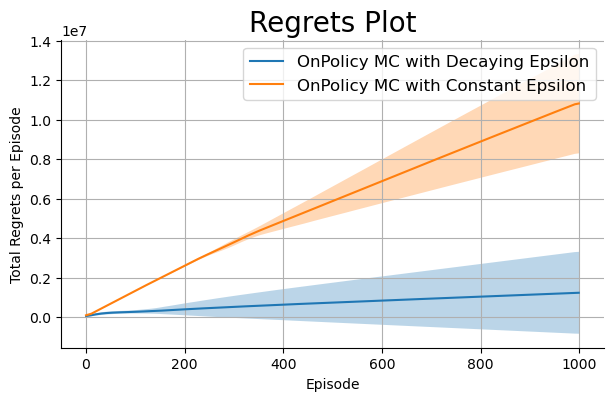

In [120]:
regrets_plot(datas=[rewards_OnMC_d, rewards_OnMC_c],
             labels=['OnPolicy MC with Decaying Epsilon', 'OnPolicy MC with Constant Epsilon'], 
             repeats=10, episodes=1000, sliding_win=True, CI=True, window_size=20)

---
# Bonus

---
## On-Policy MonteCarlo
### with decaying epsilon

#### Modiefied algorithm

In [89]:
class ModifiedOnPolicyMC(Agent):
    def __init__(self, gamma, environment, student_id, epsilon='decaying'):
        super(ModifiedOnPolicyMC, self).__init__(environment, student_id)
        self.alpha_mode = 'decaying'
        self.ep_mode = epsilon
        self.gamma = gamma
        
    def step(self):
        S_A, R = {}, {}
        state, _ = self.env.reset(seed = self.seed)
        t = 0
        while True:
            
            action = np.random.choice(a=range(self.env.action_space.n), p=self.policy[state])
#             action = self.choose_action_with_epsilon_greedy(self.epsilon, state)
            
            next_state, reward, done = self.take_action(action)
            if reward == 20:
                reward = 30
            elif reward == -1:
                reward = -5
            S_A[t] = (state, action)
            R[t+1] = reward
            state = next_state
            
            t += 1
            if done or t == 10000: break

        self.episode_reward = list(R.values())
        
        T = len(S_A)
        G = 0
        for t in range(T-1, -1, -1):
            
            G = self.gamma*G + R[t+1]
            if S_A[t] not in list(S_A.values())[:t]:
                
                self.returns[S_A[t]].append(G)
                self.q_table[S_A[t]] = np.mean(self.returns[S_A[t]])
                
                A_star = np.argmax(self.q_table[S_A[t][0]])
                for a in range(self.env.action_space.n):
                    if a == A_star:
                        self.policy[S_A[t][0], a] = 1 - self.epsilon + self.epsilon/self.env.action_space.n
                    else:
                        self.policy[S_A[t][0], a] = self.epsilon/self.env.action_space.n
        
                    

#### Training

In [90]:
M_onMC_d = ModifiedOnPolicyMC(gamma=gamma, epsilon='decaying', environment=env, student_id=student_id)
rewards_M_OnMC_d, q_tables_M_OnMC_d, learning_rates_M_OnMC_d, epsilons_M_OnMC_d = repeat(repeats=10, episodes=1000,
                                                                                         model=M_onMC_d)

REPEAT 10/10 :


100%|███████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.52it/s, Episode_Reward=-45, Steps=16]


Elapsed Time: In average 9.028s for each repeat


#### Running best model

<IPython.core.display.Javascript object>


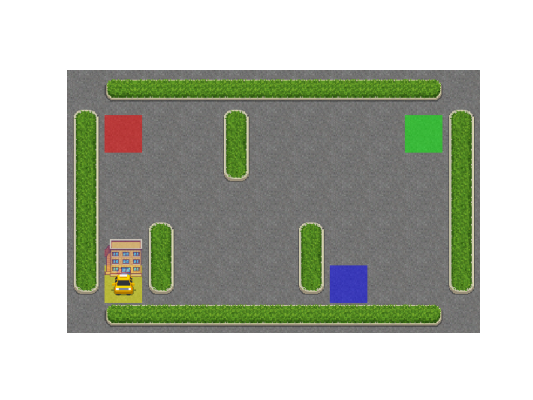

In [157]:
%matplotlib notebook
render(q_tables_M_OnMC_d, rewards_M_OnMC_d, save_name='Modified On_policy MC with decaying epsilon.gif')

#### Testing best model

Best Model:
        Reward: -45
        Steps: 16


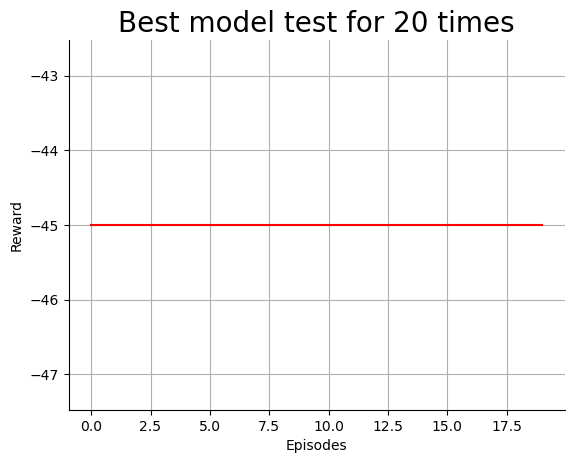

In [115]:
%matplotlib inline
episodes = 20
best_model = q_tables_M_OnMC_d[np.argmax(rewards_M_OnMC_d[:,-1])]
rewards = []
steps = []
for ep in range(episodes):
    rwrd = []
    state, _ = env.reset(seed = 476)
    for i in range(30):
        action = np.argmax(best_model[state])
        state, reward, done, _, _ = env.step(action)
        if reward == 20:
            reward = 30
        elif reward == -1:
            reward = -5
        rwrd.append(reward)
        if done: 
            break
    steps.append(len(rwrd))
    rewards.append(sum(rwrd))

print(f'Best Model:\n        Reward: {max(rewards)}\n        Steps: {min(steps)}')        
plt.plot(rewards, 'r')
plt.title(f'Best model test for {episodes} times', fontsize=20)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.grid()
sns.despine()

---
### Comparison

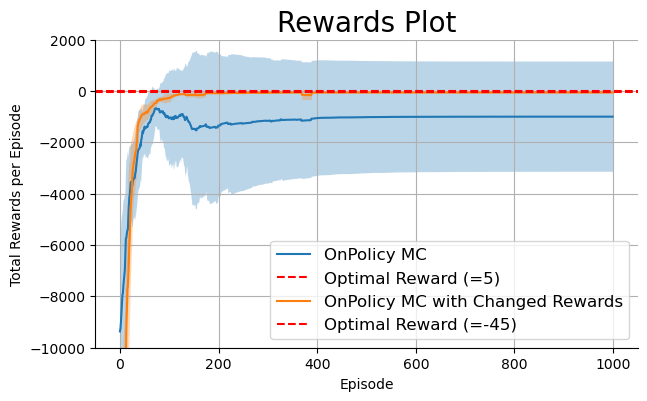

In [133]:
def modified_rewards_plot(datas, labels, repeats, episodes, sliding_win, CI, window_size=50, CL=0.95, best_reward=[5,-45]):
    fig, ax = plt.subplots(figsize=(7,4))
    for idx, data in enumerate(datas):
        if sliding_win:
            df = pd.DataFrame(data.copy())
            for row in range(repeats):
                df.iloc[row,:] = df.iloc[row,:].rolling(window=window_size, min_periods=1, center=True).mean().copy()
            plot_data = np.mean(df, axis=0)
        else:
            plot_data = np.mean(data, axis=0)
        data_mean, data_std = np.mean(df, axis=0), np.std(df, axis=0)
        tscore  = np.abs(scipy.stats.t.ppf(q=(1+CL)/2, df=repeats-1))
        ci_up   = data_mean + tscore*data_std/np.sqrt(repeats)
        ci_down = data_mean - tscore*data_std/np.sqrt(repeats)

        plt.plot(plot_data, label=labels[idx])
        plt.ylim(np.min(plot_data))
        if CI:
            plt.fill_between(range(1,episodes+1), ci_up, ci_down, alpha=0.3)
        plt.axhline(y=best_reward[idx], color='r', linestyle='--', label=f'Optimal Reward (={best_reward[idx]})')
        
    plt.title('Rewards Plot', fontsize=20)
    plt.xlabel('Episode')
    plt.ylabel('Total Rewards per Episode')
    plt.grid()
    plt.legend(fontsize=12)
    sns.despine()

modified_rewards_plot(datas=[rewards_OnMC_d, rewards_M_OnMC_d],
                      labels=['OnPolicy MC', 'OnPolicy MC with Changed Rewards'], 
                      repeats=10, episodes=1000, sliding_win=True, CI=True, window_size=20)
plt.ylim(-10000, 2000);

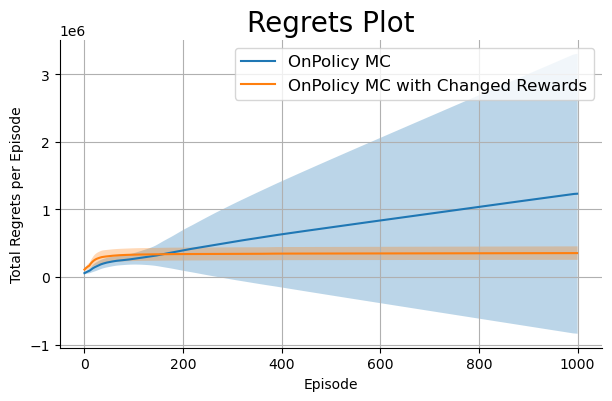

In [134]:
def modified_regrets_plot(datas, labels, repeats, episodes, sliding_win, CI, window_size=50, CL=0.95, best_reward=[5, -45]):
    plt.figure(figsize=(7,4))
    for idx, data in enumerate(datas):
        data = np.cumsum(best_reward[idx]-data, axis=1)
        if sliding_win:
            df = pd.DataFrame(data.copy())
            for row in range(repeats):
                df.iloc[row,:] = df.iloc[row,:].rolling(window=window_size, min_periods=1, center=True).mean().copy()
            plot_data = np.mean(df, axis=0)
        else:
            plot_data = np.mean(data, axis=0)
        data_mean, data_std = np.mean(df, axis=0), np.std(df, axis=0)
        tscore  = np.abs(scipy.stats.t.ppf(q=(1+CL)/2, df=repeats-1))
        ci_up   = data_mean + tscore*data_std/np.sqrt(repeats)
        ci_down = data_mean - tscore*data_std/np.sqrt(repeats)

        plt.plot(plot_data, label=labels[idx])
        if CI:
            plt.fill_between(range(1,episodes+1), ci_up, ci_down, alpha=0.3)
            
    plt.title('Regrets Plot', fontsize=20)
    plt.xlabel('Episode')
    plt.ylabel('Total Regrets per Episode')
    plt.grid()
    plt.legend(fontsize=12)
    sns.despine()

modified_regrets_plot(datas=[rewards_OnMC_d, rewards_M_OnMC_d],
                      labels=['OnPolicy MC', 'OnPolicy MC with Changed Rewards'], 
                      repeats=10, episodes=1000, sliding_win=True, CI=True, window_size=20)

---
###### The End.

---